In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xarray as xr
import spotpy
from scipy import stats, signal, optimize
import hydroeval as he
import os.path
from scipy.stats import spearmanr

In [2]:
# load primary data
data = xr.load_dataset('../data/hydro_krummh.nc').to_dataframe()
data.head()
data = data['2016':'2018']   # Q_Knock is only available in this time period

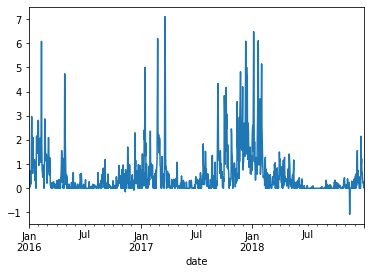

In [3]:
data.Q_Knock.resample('1d').sum().plot()

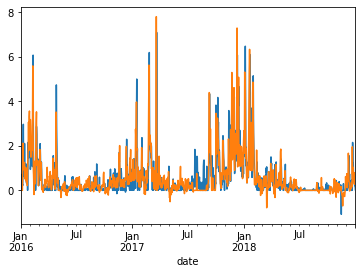

In [45]:
data['Q_Knock'].resample('1d').sum().plot()
x = [1., 2170.]
(((data['wl_LW'] - data['wl_Knock_Inner'])**x[0]).resample('1d').sum()/x[1]).plot()


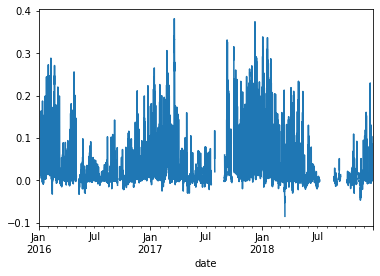

In [46]:
(((data['wl_LW'] - data['wl_Knock_Inner'])**x[0])/x[1]).plot()

In [4]:
def optidhQ (x):
    return -he.kge(((data['wl_LW'] - data['wl_Knock_Inner'])**x[0]).resample('1d').sum().values/x[1], data['Q_Knock'].resample('1d').sum().values)[0][0]

import scipy
dhQ = scipy.optimize.minimize(fun = optidhQ, x0 = [1., 2170.], method='Nelder-Mead', tol=1e-6)
print(dhQ)


 final_simplex: (array([[1.0000e+00, 2.2785e+03],
       [1.0000e+00, 2.2785e+03],
       [1.0000e+00, 2.2785e+03]]), array([-0.72968788, -0.72968788, -0.72968788]))
           fun: -0.729687881205299
       message: 'Optimization terminated successfully.'
          nfev: 199
           nit: 57
        status: 0
       success: True
             x: array([1.0000e+00, 2.2785e+03])


[[0.72968788]
 [0.73131284]
 [0.97070892]
 [1.00422867]]


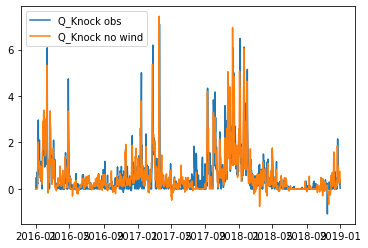

In [5]:
plt.plot(data['Q_Knock'].resample('1d').sum(), label ='Q_Knock obs')
plt.plot(((data['wl_LW'] - data['wl_Knock_Inner'])**dhQ.x[0]).resample('1d').sum() / dhQ.x[1], label ='Q_Knock no wind')
plt.legend()

print(he.kge(((data['wl_LW'] - data['wl_Knock_Inner'])**dhQ.x[0]).resample('1d').sum().values/dhQ.x[1], data['Q_Knock'].resample('1d').sum().values))

In [6]:
class spotpy_setup(object):
    def __init__(self):
        self.params = [spotpy.parameter.Uniform('exponent',low=0.1 , high=5,  optguess=1),   # exponent in flow equatoion (non-linear relation of dh-Q)
                       spotpy.parameter.Uniform('factor',low=0.01 , high=10000,  optguess=2500)     # factor in flow equatoion (linear relation of dh-Q)
                       ]
        self.evals = data['Q_Knock'].resample('1d').sum().values

    def parameters(self):
        a = spotpy.parameter.generate(self.params)
        return a
    
    def simulation(self,x):
        sim = ((data['wl_LW'] - data['wl_Knock_Inner'])**x[0]).resample('1d').sum().values/x[1]
        return sim 
    
    def evaluation(self):
        return self.evals
    
    def objectivefunction(self,simulation,evaluation, params=None, print_sublikes = False):

        import hydroeval as he
        like = he.kge(simulation, evaluation)[0][0]
        return max([like, -10])

In [7]:
spot_setup=spotpy_setup()

dbname='LHS_dh_Q'
#dbname='DREAM_WR_seepage_cs2_'+usgb+'_'+ETmeth

sampler=spotpy.algorithms.lhs(spot_setup, dbname=dbname, dbformat='csv')

#Select number of maximum repetitions
rep = 15000

# Select five chains and set the Gelman-Rubin convergence limit
nChains                = 6
convergence_limit      = 1.01
runs_after_convergence = 500

In [8]:
## To test WR setup convert this cell to code type
x = spotpy_setup.parameters(spot_setup)['random']
#x = dhQ.x
print(x)
a = spot_setup.simulation(x)

b = spot_setup.evaluation()
spot_setup.objectivefunction(a,b)

[1.24656496e+00 3.33038569e+03]


-1.4933746073405172

In [9]:
try: 
    results = spotpy.analyser.load_csv_results('LHS_dh_Q')
except:
    r_hat = sampler.sample(rep)
    results=sampler.getdata()

In [20]:
posterior = results[results['like1']>0.72]
print(spotpy.analyser.get_parameters(posterior))

[(1.13  , 4530.) (1.132 , 4616.) (1.023 , 2556.) (1.102 , 4188.)
 (1.122 , 4420.) (1.075 , 3294.) (1.058 , 3158.) (0.967 , 1888.)
 (1.097 , 4078.) (1.126 , 4504.) (1.184 , 6400.) (1.106 , 4260.)
 (1.121 , 4680.) (1.169 , 5860.) (1.165 , 5570.) (1.161 , 5708.)
 (1.061 , 3200.) (1.1455, 5350.) (0.992 , 2246.) (1.164 , 5510.)
 (1.045 , 2972.) (1.034 , 2710.) (1.105 , 3910.) (1.171 , 5908.)
 (1.127 , 4830.) (1.151 , 5292.) (1.027 , 2720.) (1.174 , 6180.)
 (1.042 , 2986.)]


In [53]:
for z in spotpy.analyser.get_parameters(posterior):
    print((1000**z[0])/z[1])

0.5418783478333395
0.5391805282240877
0.45860538558221037
0.48305137981811674
0.5255060625242327
0.5096551360420644
0.4727024729509173
0.42169457119561365
0.47923968998906186
0.5301534819967086
0.5569548959785063
0.4881917105877223
0.4928946984444592
0.5484062352628529
0.5612350748876043
0.532740894477274
0.47626648556165335
0.5106769053978477
0.421298825185126
0.5634409415840933
0.4591464120420336
0.4666923791406464
0.5282302188773732
0.5515177742078688
0.49779768116085577
0.5362658783903168
0.4430279192543371
0.5382840668187773
0.4476207356150176


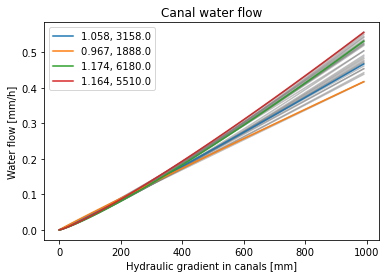

In [65]:
x = np.arange(0,1000,10)

fig, ax = plt.subplots()

for z in spotpy.analyser.get_parameters(posterior):
    ax.plot(x, (x**z[0])/z[1], alpha = 0.5, color = 'grey')
posterior_sel = [posterior[6],posterior[7],posterior[27], posterior[19]]
for z in posterior_sel:
    ax.plot(x, (x**z[1])/z[2], label = str(z[1])+', '+str(z[2]))

ax.set_xlabel("Hydraulic gradient in canals [mm]")
ax.set_ylabel("Water flow [mm/h]")
ax.set_title("Canal water flow")
ax.legend()

plt.show()

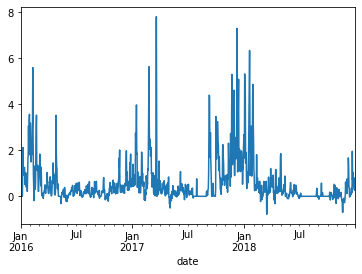

In [47]:
x = [1., 2170.]
(((data['wl_LW'] - data['wl_Knock_Inner'])**x[0]).resample('1d').sum()/x[1]).plot()

In [22]:
bestindex,bestobjf = spotpy.analyser.get_maxlikeindex(posterior)
best_model_run = posterior[bestindex]
best_model_run = best_model_run

Run number 6 has the highest objectivefunction with: 0.7314


In [60]:
fields=[word for word in best_model_run.dtype.names if word.startswith('sim')]
best_simulation = list(best_model_run[fields])
best_simulation = best_simulation

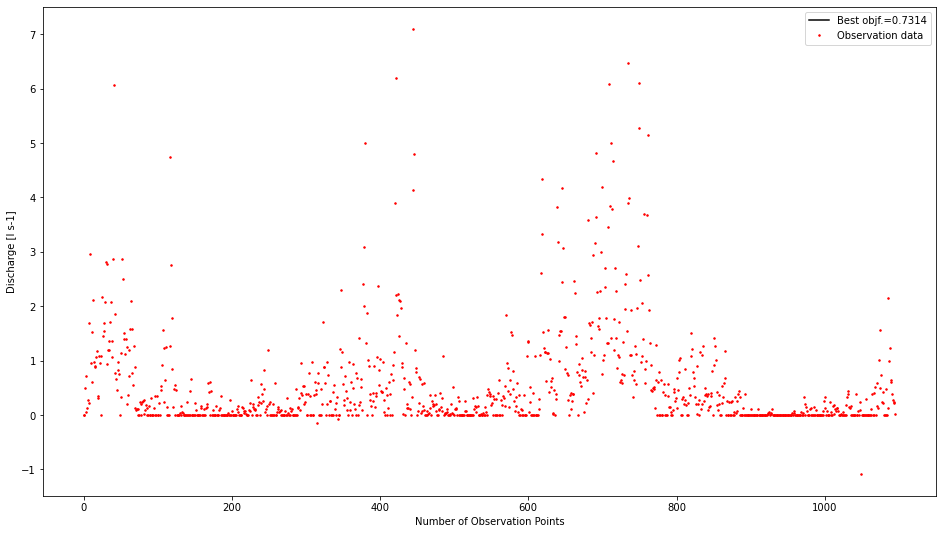

In [58]:
fig= plt.figure(figsize=(16,9))
ax = plt.subplot(1,1,1)
ax.plot(best_simulation,color='black',linestyle='solid', label='Best objf.='+str(bestobjf))
ax.plot(spot_setup.evaluation(),'r.',markersize=3, label='Observation data')
plt.xlabel('Number of Observation Points')
plt.ylabel ('Discharge [l s-1]')
plt.legend(loc='upper right')

Run number 3046 has the highest objectivefunction with: 0.7314


TypeError: Cannot cast array data from dtype({'names':['simulation_0','simulation_1','simulation_2','simulation_3','simulation_4','simulation_5','simulation_6','simulation_7','simulation_8','simulation_9','simulation_10','simulation_11','simulation_12','simulation_13','simulation_14','simulation_15','simulation_16','simulation_17','simulation_18','simulation_19','simulation_20','simulation_21','simulation_22','simulation_23','simulation_24','simulation_25','simulation_26','simulation_27','simulation_28','simulation_29','simulation_30','simulation_31','simulation_32','simulation_33','simulation_34','simulation_35','simulation_36','simulation_37','simulation_38','simulation_39','simulation_40','simulation_41','simulation_42','simulation_43','simulation_44','simulation_45','simulation_46','simulation_47','simulation_48','simulation_49','simulation_50','simulation_51','simulation_52','simulation_53','simulation_54','simulation_55','simulation_56','simulation_57','simulation_58','simulation_59','simulation_60','simulation_61','simulation_62','simulation_63','simulation_64','simulation_65','simulation_66','simulation_67','simulation_68','simulation_69','simulation_70','simulation_71','simulation_72','simulation_73','simulation_74','simulation_75','simulation_76','simulation_77','simulation_78','simulation_79','simulation_80','simulation_81','simulation_82','simulation_83','simulation_84','simulation_85','simulation_86','simulation_87','simulation_88','simulation_89','simulation_90','simulation_91','simulation_92','simulation_93','simulation_94','simulation_95','simulation_96','simulation_97','simulation_98','simulation_99','simulation_100','simulation_101','simulation_102','simulation_103','simulation_104','simulation_105','simulation_106','simulation_107','simulation_108','simulation_109','simulation_110','simulation_111','simulation_112','simulation_113','simulation_114','simulation_115','simulation_116','simulation_117','simulation_118','simulation_119','simulation_120','simulation_121','simulation_122','simulation_123','simulation_124','simulation_125','simulation_126','simulation_127','simulation_128','simulation_129','simulation_130','simulation_131','simulation_132','simulation_133','simulation_134','simulation_135','simulation_136','simulation_137','simulation_138','simulation_139','simulation_140','simulation_141','simulation_142','simulation_143','simulation_144','simulation_145','simulation_146','simulation_147','simulation_148','simulation_149','simulation_150','simulation_151','simulation_152','simulation_153','simulation_154','simulation_155','simulation_156','simulation_157','simulation_158','simulation_159','simulation_160','simulation_161','simulation_162','simulation_163','simulation_164','simulation_165','simulation_166','simulation_167','simulation_168','simulation_169','simulation_170','simulation_171','simulation_172','simulation_173','simulation_174','simulation_175','simulation_176','simulation_177','simulation_178','simulation_179','simulation_180','simulation_181','simulation_182','simulation_183','simulation_184','simulation_185','simulation_186','simulation_187','simulation_188','simulation_189','simulation_190','simulation_191','simulation_192','simulation_193','simulation_194','simulation_195','simulation_196','simulation_197','simulation_198','simulation_199','simulation_200','simulation_201','simulation_202','simulation_203','simulation_204','simulation_205','simulation_206','simulation_207','simulation_208','simulation_209','simulation_210','simulation_211','simulation_212','simulation_213','simulation_214','simulation_215','simulation_216','simulation_217','simulation_218','simulation_219','simulation_220','simulation_221','simulation_222','simulation_223','simulation_224','simulation_225','simulation_226','simulation_227','simulation_228','simulation_229','simulation_230','simulation_231','simulation_232','simulation_233','simulation_234','simulation_235','simulation_236','simulation_237','simulation_238','simulation_239','simulation_240','simulation_241','simulation_242','simulation_243','simulation_244','simulation_245','simulation_246','simulation_247','simulation_248','simulation_249','simulation_250','simulation_251','simulation_252','simulation_253','simulation_254','simulation_255','simulation_256','simulation_257','simulation_258','simulation_259','simulation_260','simulation_261','simulation_262','simulation_263','simulation_264','simulation_265','simulation_266','simulation_267','simulation_268','simulation_269','simulation_270','simulation_271','simulation_272','simulation_273','simulation_274','simulation_275','simulation_276','simulation_277','simulation_278','simulation_279','simulation_280','simulation_281','simulation_282','simulation_283','simulation_284','simulation_285','simulation_286','simulation_287','simulation_288','simulation_289','simulation_290','simulation_291','simulation_292','simulation_293','simulation_294','simulation_295','simulation_296','simulation_297','simulation_298','simulation_299','simulation_300','simulation_301','simulation_302','simulation_303','simulation_304','simulation_305','simulation_306','simulation_307','simulation_308','simulation_309','simulation_310','simulation_311','simulation_312','simulation_313','simulation_314','simulation_315','simulation_316','simulation_317','simulation_318','simulation_319','simulation_320','simulation_321','simulation_322','simulation_323','simulation_324','simulation_325','simulation_326','simulation_327','simulation_328','simulation_329','simulation_330','simulation_331','simulation_332','simulation_333','simulation_334','simulation_335','simulation_336','simulation_337','simulation_338','simulation_339','simulation_340','simulation_341','simulation_342','simulation_343','simulation_344','simulation_345','simulation_346','simulation_347','simulation_348','simulation_349','simulation_350','simulation_351','simulation_352','simulation_353','simulation_354','simulation_355','simulation_356','simulation_357','simulation_358','simulation_359','simulation_360','simulation_361','simulation_362','simulation_363','simulation_364','simulation_365','simulation_366','simulation_367','simulation_368','simulation_369','simulation_370','simulation_371','simulation_372','simulation_373','simulation_374','simulation_375','simulation_376','simulation_377','simulation_378','simulation_379','simulation_380','simulation_381','simulation_382','simulation_383','simulation_384','simulation_385','simulation_386','simulation_387','simulation_388','simulation_389','simulation_390','simulation_391','simulation_392','simulation_393','simulation_394','simulation_395','simulation_396','simulation_397','simulation_398','simulation_399','simulation_400','simulation_401','simulation_402','simulation_403','simulation_404','simulation_405','simulation_406','simulation_407','simulation_408','simulation_409','simulation_410','simulation_411','simulation_412','simulation_413','simulation_414','simulation_415','simulation_416','simulation_417','simulation_418','simulation_419','simulation_420','simulation_421','simulation_422','simulation_423','simulation_424','simulation_425','simulation_426','simulation_427','simulation_428','simulation_429','simulation_430','simulation_431','simulation_432','simulation_433','simulation_434','simulation_435','simulation_436','simulation_437','simulation_438','simulation_439','simulation_440','simulation_441','simulation_442','simulation_443','simulation_444','simulation_445','simulation_446','simulation_447','simulation_448','simulation_449','simulation_450','simulation_451','simulation_452','simulation_453','simulation_454','simulation_455','simulation_456','simulation_457','simulation_458','simulation_459','simulation_460','simulation_461','simulation_462','simulation_463','simulation_464','simulation_465','simulation_466','simulation_467','simulation_468','simulation_469','simulation_470','simulation_471','simulation_472','simulation_473','simulation_474','simulation_475','simulation_476','simulation_477','simulation_478','simulation_479','simulation_480','simulation_481','simulation_482','simulation_483','simulation_484','simulation_485','simulation_486','simulation_487','simulation_488','simulation_489','simulation_490','simulation_491','simulation_492','simulation_493','simulation_494','simulation_495','simulation_496','simulation_497','simulation_498','simulation_499','simulation_500','simulation_501','simulation_502','simulation_503','simulation_504','simulation_505','simulation_506','simulation_507','simulation_508','simulation_509','simulation_510','simulation_511','simulation_512','simulation_513','simulation_514','simulation_515','simulation_516','simulation_517','simulation_518','simulation_519','simulation_520','simulation_521','simulation_522','simulation_523','simulation_524','simulation_525','simulation_526','simulation_527','simulation_528','simulation_529','simulation_530','simulation_531','simulation_532','simulation_533','simulation_534','simulation_535','simulation_536','simulation_537','simulation_538','simulation_539','simulation_540','simulation_541','simulation_542','simulation_543','simulation_544','simulation_545','simulation_546','simulation_547','simulation_548','simulation_549','simulation_550','simulation_551','simulation_552','simulation_553','simulation_554','simulation_555','simulation_556','simulation_557','simulation_558','simulation_559','simulation_560','simulation_561','simulation_562','simulation_563','simulation_564','simulation_565','simulation_566','simulation_567','simulation_568','simulation_569','simulation_570','simulation_571','simulation_572','simulation_573','simulation_574','simulation_575','simulation_576','simulation_577','simulation_578','simulation_579','simulation_580','simulation_581','simulation_582','simulation_583','simulation_584','simulation_585','simulation_586','simulation_587','simulation_588','simulation_589','simulation_590','simulation_591','simulation_592','simulation_593','simulation_594','simulation_595','simulation_596','simulation_597','simulation_598','simulation_599','simulation_600','simulation_601','simulation_602','simulation_603','simulation_604','simulation_605','simulation_606','simulation_607','simulation_608','simulation_609','simulation_610','simulation_611','simulation_612','simulation_613','simulation_614','simulation_615','simulation_616','simulation_617','simulation_618','simulation_619','simulation_620','simulation_621','simulation_622','simulation_623','simulation_624','simulation_625','simulation_626','simulation_627','simulation_628','simulation_629','simulation_630','simulation_631','simulation_632','simulation_633','simulation_634','simulation_635','simulation_636','simulation_637','simulation_638','simulation_639','simulation_640','simulation_641','simulation_642','simulation_643','simulation_644','simulation_645','simulation_646','simulation_647','simulation_648','simulation_649','simulation_650','simulation_651','simulation_652','simulation_653','simulation_654','simulation_655','simulation_656','simulation_657','simulation_658','simulation_659','simulation_660','simulation_661','simulation_662','simulation_663','simulation_664','simulation_665','simulation_666','simulation_667','simulation_668','simulation_669','simulation_670','simulation_671','simulation_672','simulation_673','simulation_674','simulation_675','simulation_676','simulation_677','simulation_678','simulation_679','simulation_680','simulation_681','simulation_682','simulation_683','simulation_684','simulation_685','simulation_686','simulation_687','simulation_688','simulation_689','simulation_690','simulation_691','simulation_692','simulation_693','simulation_694','simulation_695','simulation_696','simulation_697','simulation_698','simulation_699','simulation_700','simulation_701','simulation_702','simulation_703','simulation_704','simulation_705','simulation_706','simulation_707','simulation_708','simulation_709','simulation_710','simulation_711','simulation_712','simulation_713','simulation_714','simulation_715','simulation_716','simulation_717','simulation_718','simulation_719','simulation_720','simulation_721','simulation_722','simulation_723','simulation_724','simulation_725','simulation_726','simulation_727','simulation_728','simulation_729','simulation_730','simulation_731','simulation_732','simulation_733','simulation_734','simulation_735','simulation_736','simulation_737','simulation_738','simulation_739','simulation_740','simulation_741','simulation_742','simulation_743','simulation_744','simulation_745','simulation_746','simulation_747','simulation_748','simulation_749','simulation_750','simulation_751','simulation_752','simulation_753','simulation_754','simulation_755','simulation_756','simulation_757','simulation_758','simulation_759','simulation_760','simulation_761','simulation_762','simulation_763','simulation_764','simulation_765','simulation_766','simulation_767','simulation_768','simulation_769','simulation_770','simulation_771','simulation_772','simulation_773','simulation_774','simulation_775','simulation_776','simulation_777','simulation_778','simulation_779','simulation_780','simulation_781','simulation_782','simulation_783','simulation_784','simulation_785','simulation_786','simulation_787','simulation_788','simulation_789','simulation_790','simulation_791','simulation_792','simulation_793','simulation_794','simulation_795','simulation_796','simulation_797','simulation_798','simulation_799','simulation_800','simulation_801','simulation_802','simulation_803','simulation_804','simulation_805','simulation_806','simulation_807','simulation_808','simulation_809','simulation_810','simulation_811','simulation_812','simulation_813','simulation_814','simulation_815','simulation_816','simulation_817','simulation_818','simulation_819','simulation_820','simulation_821','simulation_822','simulation_823','simulation_824','simulation_825','simulation_826','simulation_827','simulation_828','simulation_829','simulation_830','simulation_831','simulation_832','simulation_833','simulation_834','simulation_835','simulation_836','simulation_837','simulation_838','simulation_839','simulation_840','simulation_841','simulation_842','simulation_843','simulation_844','simulation_845','simulation_846','simulation_847','simulation_848','simulation_849','simulation_850','simulation_851','simulation_852','simulation_853','simulation_854','simulation_855','simulation_856','simulation_857','simulation_858','simulation_859','simulation_860','simulation_861','simulation_862','simulation_863','simulation_864','simulation_865','simulation_866','simulation_867','simulation_868','simulation_869','simulation_870','simulation_871','simulation_872','simulation_873','simulation_874','simulation_875','simulation_876','simulation_877','simulation_878','simulation_879','simulation_880','simulation_881','simulation_882','simulation_883','simulation_884','simulation_885','simulation_886','simulation_887','simulation_888','simulation_889','simulation_890','simulation_891','simulation_892','simulation_893','simulation_894','simulation_895','simulation_896','simulation_897','simulation_898','simulation_899','simulation_900','simulation_901','simulation_902','simulation_903','simulation_904','simulation_905','simulation_906','simulation_907','simulation_908','simulation_909','simulation_910','simulation_911','simulation_912','simulation_913','simulation_914','simulation_915','simulation_916','simulation_917','simulation_918','simulation_919','simulation_920','simulation_921','simulation_922','simulation_923','simulation_924','simulation_925','simulation_926','simulation_927','simulation_928','simulation_929','simulation_930','simulation_931','simulation_932','simulation_933','simulation_934','simulation_935','simulation_936','simulation_937','simulation_938','simulation_939','simulation_940','simulation_941','simulation_942','simulation_943','simulation_944','simulation_945','simulation_946','simulation_947','simulation_948','simulation_949','simulation_950','simulation_951','simulation_952','simulation_953','simulation_954','simulation_955','simulation_956','simulation_957','simulation_958','simulation_959','simulation_960','simulation_961','simulation_962','simulation_963','simulation_964','simulation_965','simulation_966','simulation_967','simulation_968','simulation_969','simulation_970','simulation_971','simulation_972','simulation_973','simulation_974','simulation_975','simulation_976','simulation_977','simulation_978','simulation_979','simulation_980','simulation_981','simulation_982','simulation_983','simulation_984','simulation_985','simulation_986','simulation_987','simulation_988','simulation_989','simulation_990','simulation_991','simulation_992','simulation_993','simulation_994','simulation_995','simulation_996','simulation_997','simulation_998','simulation_999','simulation_1000','simulation_1001','simulation_1002','simulation_1003','simulation_1004','simulation_1005','simulation_1006','simulation_1007','simulation_1008','simulation_1009','simulation_1010','simulation_1011','simulation_1012','simulation_1013','simulation_1014','simulation_1015','simulation_1016','simulation_1017','simulation_1018','simulation_1019','simulation_1020','simulation_1021','simulation_1022','simulation_1023','simulation_1024','simulation_1025','simulation_1026','simulation_1027','simulation_1028','simulation_1029','simulation_1030','simulation_1031','simulation_1032','simulation_1033','simulation_1034','simulation_1035','simulation_1036','simulation_1037','simulation_1038','simulation_1039','simulation_1040','simulation_1041','simulation_1042','simulation_1043','simulation_1044','simulation_1045','simulation_1046','simulation_1047','simulation_1048','simulation_1049','simulation_1050','simulation_1051','simulation_1052','simulation_1053','simulation_1054','simulation_1055','simulation_1056','simulation_1057','simulation_1058','simulation_1059','simulation_1060','simulation_1061','simulation_1062','simulation_1063','simulation_1064','simulation_1065','simulation_1066','simulation_1067','simulation_1068','simulation_1069','simulation_1070','simulation_1071','simulation_1072','simulation_1073','simulation_1074','simulation_1075','simulation_1076','simulation_1077','simulation_1078','simulation_1079','simulation_1080','simulation_1081','simulation_1082','simulation_1083','simulation_1084','simulation_1085','simulation_1086','simulation_1087','simulation_1088','simulation_1089','simulation_1090','simulation_1091','simulation_1092','simulation_1093','simulation_1094','simulation_1095'], 'formats':['<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8','<f8'], 'offsets':[24,32,40,48,56,64,72,80,88,96,104,112,120,128,136,144,152,160,168,176,184,192,200,208,216,224,232,240,248,256,264,272,280,288,296,304,312,320,328,336,344,352,360,368,376,384,392,400,408,416,424,432,440,448,456,464,472,480,488,496,504,512,520,528,536,544,552,560,568,576,584,592,600,608,616,624,632,640,648,656,664,672,680,688,696,704,712,720,728,736,744,752,760,768,776,784,792,800,808,816,824,832,840,848,856,864,872,880,888,896,904,912,920,928,936,944,952,960,968,976,984,992,1000,1008,1016,1024,1032,1040,1048,1056,1064,1072,1080,1088,1096,1104,1112,1120,1128,1136,1144,1152,1160,1168,1176,1184,1192,1200,1208,1216,1224,1232,1240,1248,1256,1264,1272,1280,1288,1296,1304,1312,1320,1328,1336,1344,1352,1360,1368,1376,1384,1392,1400,1408,1416,1424,1432,1440,1448,1456,1464,1472,1480,1488,1496,1504,1512,1520,1528,1536,1544,1552,1560,1568,1576,1584,1592,1600,1608,1616,1624,1632,1640,1648,1656,1664,1672,1680,1688,1696,1704,1712,1720,1728,1736,1744,1752,1760,1768,1776,1784,1792,1800,1808,1816,1824,1832,1840,1848,1856,1864,1872,1880,1888,1896,1904,1912,1920,1928,1936,1944,1952,1960,1968,1976,1984,1992,2000,2008,2016,2024,2032,2040,2048,2056,2064,2072,2080,2088,2096,2104,2112,2120,2128,2136,2144,2152,2160,2168,2176,2184,2192,2200,2208,2216,2224,2232,2240,2248,2256,2264,2272,2280,2288,2296,2304,2312,2320,2328,2336,2344,2352,2360,2368,2376,2384,2392,2400,2408,2416,2424,2432,2440,2448,2456,2464,2472,2480,2488,2496,2504,2512,2520,2528,2536,2544,2552,2560,2568,2576,2584,2592,2600,2608,2616,2624,2632,2640,2648,2656,2664,2672,2680,2688,2696,2704,2712,2720,2728,2736,2744,2752,2760,2768,2776,2784,2792,2800,2808,2816,2824,2832,2840,2848,2856,2864,2872,2880,2888,2896,2904,2912,2920,2928,2936,2944,2952,2960,2968,2976,2984,2992,3000,3008,3016,3024,3032,3040,3048,3056,3064,3072,3080,3088,3096,3104,3112,3120,3128,3136,3144,3152,3160,3168,3176,3184,3192,3200,3208,3216,3224,3232,3240,3248,3256,3264,3272,3280,3288,3296,3304,3312,3320,3328,3336,3344,3352,3360,3368,3376,3384,3392,3400,3408,3416,3424,3432,3440,3448,3456,3464,3472,3480,3488,3496,3504,3512,3520,3528,3536,3544,3552,3560,3568,3576,3584,3592,3600,3608,3616,3624,3632,3640,3648,3656,3664,3672,3680,3688,3696,3704,3712,3720,3728,3736,3744,3752,3760,3768,3776,3784,3792,3800,3808,3816,3824,3832,3840,3848,3856,3864,3872,3880,3888,3896,3904,3912,3920,3928,3936,3944,3952,3960,3968,3976,3984,3992,4000,4008,4016,4024,4032,4040,4048,4056,4064,4072,4080,4088,4096,4104,4112,4120,4128,4136,4144,4152,4160,4168,4176,4184,4192,4200,4208,4216,4224,4232,4240,4248,4256,4264,4272,4280,4288,4296,4304,4312,4320,4328,4336,4344,4352,4360,4368,4376,4384,4392,4400,4408,4416,4424,4432,4440,4448,4456,4464,4472,4480,4488,4496,4504,4512,4520,4528,4536,4544,4552,4560,4568,4576,4584,4592,4600,4608,4616,4624,4632,4640,4648,4656,4664,4672,4680,4688,4696,4704,4712,4720,4728,4736,4744,4752,4760,4768,4776,4784,4792,4800,4808,4816,4824,4832,4840,4848,4856,4864,4872,4880,4888,4896,4904,4912,4920,4928,4936,4944,4952,4960,4968,4976,4984,4992,5000,5008,5016,5024,5032,5040,5048,5056,5064,5072,5080,5088,5096,5104,5112,5120,5128,5136,5144,5152,5160,5168,5176,5184,5192,5200,5208,5216,5224,5232,5240,5248,5256,5264,5272,5280,5288,5296,5304,5312,5320,5328,5336,5344,5352,5360,5368,5376,5384,5392,5400,5408,5416,5424,5432,5440,5448,5456,5464,5472,5480,5488,5496,5504,5512,5520,5528,5536,5544,5552,5560,5568,5576,5584,5592,5600,5608,5616,5624,5632,5640,5648,5656,5664,5672,5680,5688,5696,5704,5712,5720,5728,5736,5744,5752,5760,5768,5776,5784,5792,5800,5808,5816,5824,5832,5840,5848,5856,5864,5872,5880,5888,5896,5904,5912,5920,5928,5936,5944,5952,5960,5968,5976,5984,5992,6000,6008,6016,6024,6032,6040,6048,6056,6064,6072,6080,6088,6096,6104,6112,6120,6128,6136,6144,6152,6160,6168,6176,6184,6192,6200,6208,6216,6224,6232,6240,6248,6256,6264,6272,6280,6288,6296,6304,6312,6320,6328,6336,6344,6352,6360,6368,6376,6384,6392,6400,6408,6416,6424,6432,6440,6448,6456,6464,6472,6480,6488,6496,6504,6512,6520,6528,6536,6544,6552,6560,6568,6576,6584,6592,6600,6608,6616,6624,6632,6640,6648,6656,6664,6672,6680,6688,6696,6704,6712,6720,6728,6736,6744,6752,6760,6768,6776,6784,6792,6800,6808,6816,6824,6832,6840,6848,6856,6864,6872,6880,6888,6896,6904,6912,6920,6928,6936,6944,6952,6960,6968,6976,6984,6992,7000,7008,7016,7024,7032,7040,7048,7056,7064,7072,7080,7088,7096,7104,7112,7120,7128,7136,7144,7152,7160,7168,7176,7184,7192,7200,7208,7216,7224,7232,7240,7248,7256,7264,7272,7280,7288,7296,7304,7312,7320,7328,7336,7344,7352,7360,7368,7376,7384,7392,7400,7408,7416,7424,7432,7440,7448,7456,7464,7472,7480,7488,7496,7504,7512,7520,7528,7536,7544,7552,7560,7568,7576,7584,7592,7600,7608,7616,7624,7632,7640,7648,7656,7664,7672,7680,7688,7696,7704,7712,7720,7728,7736,7744,7752,7760,7768,7776,7784,7792,7800,7808,7816,7824,7832,7840,7848,7856,7864,7872,7880,7888,7896,7904,7912,7920,7928,7936,7944,7952,7960,7968,7976,7984,7992,8000,8008,8016,8024,8032,8040,8048,8056,8064,8072,8080,8088,8096,8104,8112,8120,8128,8136,8144,8152,8160,8168,8176,8184,8192,8200,8208,8216,8224,8232,8240,8248,8256,8264,8272,8280,8288,8296,8304,8312,8320,8328,8336,8344,8352,8360,8368,8376,8384,8392,8400,8408,8416,8424,8432,8440,8448,8456,8464,8472,8480,8488,8496,8504,8512,8520,8528,8536,8544,8552,8560,8568,8576,8584,8592,8600,8608,8616,8624,8632,8640,8648,8656,8664,8672,8680,8688,8696,8704,8712,8720,8728,8736,8744,8752,8760,8768,8776,8784], 'itemsize':8800}) to dtype('float64') according to the rule 'unsafe'

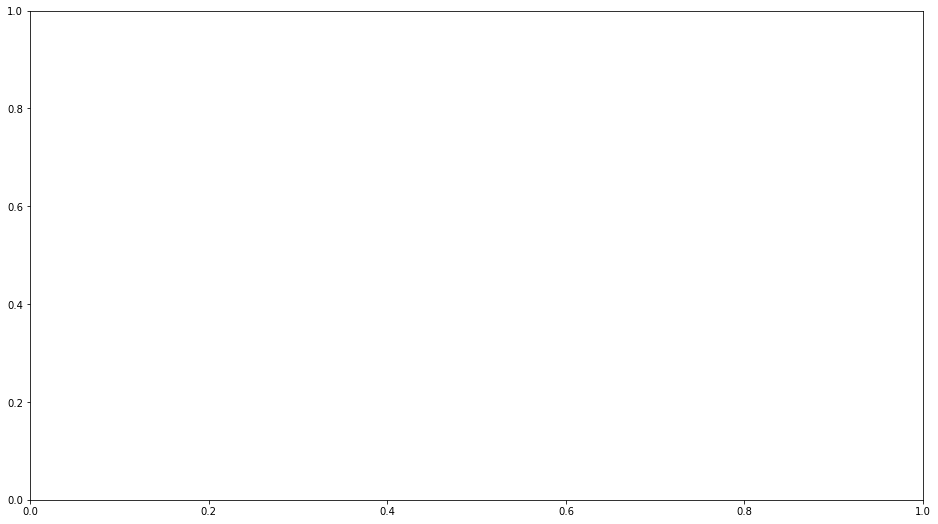

In [15]:
ax.plot(spot_setup.evaluation(),'r.',markersize=3, label='Observation data')
plt.xlabel('Number of Observation Points')
plt.ylabel ('Discharge [l s-1]')
plt.legend(loc='upper right')
fig.savefig('SCEUA_best_modelrun.png',dpi=300)